###########################################################################<br>
\# This code is associated to the paper:<br>
\# <b>Provable bounds for noise-free expectation values computed from noisy samples</b><br>
\# (https://arxiv.org/abs/2312.00733)<br>
\# <br>
\# (C) Copyright IBM 2024.<br>
\# <br>
\# Any modifications or derivative works of this code must retain<br>
\# this copyright notice, and modified files need to carry a notice<br>
\# indicating that they have been altered from the originals.<br>
###########################################################################

# 127-qubit QAOA

QAOA for cubic binary optimization problems with 127 binary variables presented in https://arxiv.org/abs/2312.00733. 

Original source of problem and circuits: 
- [1] paper: "Quantum Annealing vs. QAOA: 127 Qubit Higher-Order Ising Problems on NISQ Computers", [arXiv:2301.00520](https://arxiv.org/abs/2301.00520) (2023). 
- [2] repository: https://github.com/lanl/QAOA_vs_QA

This notebook contains the code for:
- [Figure 4](#Figure-4)
- [Figure 5](#Figure-5)
- [Table 2](#Table-2)

In [1]:
import os
from zipfile import ZipFile
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, qpy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

import ast
import dimod

import mthree

In [2]:
# noise-free QAOA expectation values for p=1,...,5 from original source [1]
noise_free_exp_vals = [
    -79.78604234,
    -109.3531247358,
    -125.371947554689,
    -137.224838336353,
    -145.540716855902
]

In [3]:
file = open('./data/ibm_sherbrooke_0.txt', 'r')
instance = ast.literal_eval(file.read())
file.close()

# combine all separate terms into one dictionary for linear, quadratic, and cubic terms
# The original problem is defined such that the terms are already nicely partitioned by 3 edge coloring or bipartition, but for evaluating samplees we do not need this
lin = {}
for a in instance[0]:
    lin = {**lin, **a}
h = {}
for k in lin:
    h[(k, )] = lin[k]
J = {}
for a in instance[1]:
    J = {**J, **a}
cubic = {}
for a in instance[2]:
    cubic = {**cubic, **a}

# this polynomial allows us to evaluate any spin vector on the cost function of the entire Hamiltonian
poly = dimod.BinaryPolynomial({**cubic, **h, **J}, dimod.SPIN)

# optimal solution
optimal = {1: 1, 4: 1, 5: 1, 7: 1, 10: 1, 15: 1, 16: 1, 105: 1, 11: 1, 20: 1, 24: 1, 32: 1, 35: 1, 37: 1, 29: 1, 39: 1, 40: 1, 
           42: 1, 43: 1, 38: 1, 45: 1, 47: 1, 44: 1, 49: 1, 51: 1, 46: 1, 48: 1, 59: 1, 62: 1, 65: 1, 71: 1, 75: 1, 79: 1, 82: 1, 
           84: 1, 87: 1, 89: 1, 86: 1, 92: 1, 94: 1, 95: 1, 90: 1, 98: 1, 100: 1, 103: 1, 104: 1, 106: 1, 107: 1, 108: 1, 115: 1, 
           116: 1, 117: 1, 119: 1, 118: 1, 124: 1, 125: 1, 121: 1, 25: 1, 33: 1, 110: 1, 111: 1, 52: 1, 57: 1, 66: 1, 23: 1, 
           69: 1, 72: 1, 91: 1, 0: -1, 2: -1, 3: -1, 6: -1, 8: -1, 9: -1, 12: -1, 13: -1, 14: -1, 17: -1, 18: -1, 19: -1, 21: -1, 
           22: -1, 26: -1, 27: -1, 28: -1, 30: -1, 31: -1, 34: -1, 36: -1, 41: -1, 50: -1, 53: -1, 54: -1, 55: -1, 56: -1, 58: -1, 
           60: -1, 61: -1, 63: -1, 64: -1, 67: -1, 68: -1, 70: -1, 73: -1, 74: -1, 76: -1, 77: -1, 78: -1, 80: -1, 81: -1, 83: -1, 
           85: -1, 88: -1, 93: -1, 96: -1, 97: -1, 99: -1, 101: -1, 102: -1, 109: -1, 112: -1, 113: -1, 114: -1, 120: -1, 122: -1, 
           123: -1, 126: -1}

# optimal energy
opt_val = poly.energy(optimal)
print('opt_val:', opt_val)

opt_val: -188.0


In [4]:
# load circuits
with open('./data/circuits_127_qubits.qpy', 'rb') as f:
    qcs = qpy.load(f)

In [5]:
def unzip_and_load_results_file(filename):
    
    # unzip file
    if not os.path.isfile(f'results/{filename}'):
        print(f'unzip {filename}.zip... ', end='')
        with ZipFile(f'results/{filename}.zip', 'r') as zf:
            zf.extractall(path='results/')
            print('done!')

    # load file
    print(f'load  {filename}...     ', end='')
    with open(f'results/{filename}', 'r') as f:
        data = json.load(f)
    print('done!')
    return data

In [6]:
# instantiate Qiskit runtime service
service = QiskitRuntimeService(channel='ibm_quantum', instance='quantum-demonstrations/high-priority/qemcvar')

In [7]:
# select backend
backend = service.backend('ibm_kyiv')

# Initial layout and layer fidelity

The initial layout and layer fidelities can be evaluated using the following notebook:

https://github.com/qiskit-community/qiskit-device-benchmarking/blob/main/notebooks/layer_fidelity.ipynb

The tutorial in can be adjusted to use the following 3 layers, i.e., `two_disjoint_layers=layers` with `layers` given below, as well as all 127 qubits, i.e., `best_qubit_chain = range(127)`. However, in case there are bad two-qubit gates where, e.g., the calibration failed, the layer fidelity is not too meaningful anymore as it becomes too low. This is in contrast to smaller experiments where want has some flexibility to circumvent bad connections/qubits.

In [8]:
# uses all qubits
initial_layout = list(range(127))

In [9]:
# takes layer of 2-qubit pairs and maps it to physically supported gates in coupling map (which can be asymmetric)
def map_to_layer(layer, coupling_map=backend.coupling_map):
    layer_ = [tuple(e) for e in layer]
    set_ = set()
    for e in layer_:
        if e in coupling_map: 
            set_.add(e)
        else:
            e = tuple([e[1], e[0]])
            if e in coupling_map:
                set_.add(e)
            else:
                print(f'error, gate {e} not in coupling map')
    layer_ = list(set_)
    return layer_

In [10]:
# define layers
coupling_map = backend.coupling_map

layer_1 = map_to_layer([[62, 72], [60, 61], [64, 63], [81, 80], [83, 82], [41, 53], [58, 59], [66, 65], [45, 54], [79, 91], [77, 78], [85, 84], [102, 92], [39, 40], [43, 42], [56, 57], [68, 67], [47, 46], [98, 99], [96, 97], [75, 76], [87, 86], [104, 103], [100, 101], [37, 38], [20, 33], [24, 34], [70, 69], [49, 55], [28, 35], [118, 110], [114, 109], [94, 95], [89, 88], [106, 93], [122, 111], [18, 19], [22, 21], [26, 25], [51, 50], [30, 29], [116, 117], [120, 119], [108, 107], [124, 123], [0, 14], [4, 15], [8, 16], [32, 36], [12, 17], [126, 112], [2, 1], [6, 5], [10, 9], [62, 72], [60, 61], [64, 63], [81, 80], [83, 82], [41, 53], [58, 59], [66, 65], [45, 54], [79, 91], [77, 78], [85, 84], [102, 92], [39, 40], [43, 42], [56, 57], [68, 67], [47, 46], [98, 99], [96, 97], [75, 76], [87, 86], [104, 103], [100, 101], [37, 38], [20, 33], [24, 34], [70, 69], [49, 55], [28, 35], [118, 110], [114, 109], [94, 95], [89, 88], [106, 93], [122, 111], [18, 19], [22, 21], [26, 25], [51, 50], [30, 29], [116, 117], [120, 119], [108, 107], [124, 123], [0, 14], [4, 15], [8, 16], [32, 36], [12, 17], [126, 112], [2, 1], [6, 5], [10, 9]])
layer_2 = map_to_layer([[62, 61], [81, 72], [60, 53], [64, 65], [79, 80], [83, 84], [41, 40], [58, 57], [66, 67], [45, 46], [98, 91], [77, 71], [85, 73], [43, 44], [102, 103], [39, 38], [56, 52], [68, 69], [47, 48], [100, 99], [96, 109], [75, 90], [87, 88], [104, 111], [20, 19], [24, 23], [70, 74], [49, 50], [28, 27], [106, 105], [118, 117], [114, 115], [122, 121], [18, 14], [22, 15], [26, 16], [51, 36], [30, 31], [108, 112], [124, 125], [0, 1], [4, 3], [8, 7], [12, 11], [62, 61], [81, 72], [60, 53], [64, 65], [79, 80], [83, 84], [41, 40], [58, 57], [66, 67], [45, 46], [98, 91], [77, 71], [85, 73], [43, 44], [102, 103], [39, 38], [56, 52], [68, 69], [47, 48], [100, 99], [96, 109], [75, 90], [87, 88], [104, 111], [20, 19], [24, 23], [70, 74], [49, 50], [28, 27], [106, 105], [118, 117], [114, 115], [122, 121], [18, 14], [22, 15], [26, 16], [51, 36], [30, 31], [108, 112], [124, 125], [0, 1], [4, 3], [8, 7], [12, 11]])
layer_3 = map_to_layer([[62, 63], [81, 82], [60, 59], [64, 54], [79, 78], [83, 92], [41, 42], [58, 71], [66, 73], [45, 44], [98, 97], [77, 76], [85, 86], [102, 101], [39, 33], [43, 34], [68, 55], [47, 35], [37, 52], [49, 48], [100, 110], [96, 95], [87, 93], [104, 105], [20, 21], [24, 25], [28, 29], [94, 90], [22, 23], [89, 74], [26, 27], [118, 119], [114, 113], [106, 107], [122, 123], [30, 17], [116, 115], [120, 121], [32, 31], [4, 5], [8, 9], [12, 13], [126, 125], [2, 3], [6, 7], [10, 11], [62, 63], [81, 82], [60, 59], [64, 54], [79, 78], [83, 92], [41, 42], [58, 71], [66, 73], [45, 44], [98, 97], [77, 76], [85, 86], [102, 101], [39, 33], [43, 34], [68, 55], [47, 35], [37, 52], [49, 48], [100, 110], [96, 95], [87, 93], [104, 105], [20, 21], [24, 25], [28, 29], [94, 90], [22, 23], [89, 74], [26, 27], [118, 119], [114, 113], [106, 107], [122, 123], [30, 17], [116, 115], [120, 121], [32, 31], [4, 5], [8, 9], [12, 13], [126, 125], [2, 3], [6, 7], [10, 11]])

# layers to use in layer fidelity experiment
layers = [layer_1, layer_2, layer_3]

# use all qubits
qubits = range(127)

In [11]:
##########################################################################################
# insert initial layout from layer fidelity experiments
lf_1 = 0.2190
lf_2 = 0.1579
lf_3 = 0.2590
##########################################################################################

lf = lf_1 * lf_2 * lf_3
cnot_fidelity = lf**(1/144)
gamma_cnot = 1/cnot_fidelity**2
print('gamma_cnot:', gamma_cnot)

gamma_cnot: 1.0676839010681554


# Transpile circuits

In [12]:
# transpile circuits to backend
preset_manager = generate_preset_pass_manager(backend=backend, optimization_level=0, 
                                              initial_layout=initial_layout)
transpiled_qcs = preset_manager.run(qcs)    

# Run circuits

In [13]:
# uncomment to run circuits, otherwise, precomputed data will be loaded
# note that this will also overwrite the M3 measurement error calibrations
run_circuits = False

In [14]:
cals_file = f'results/m3_cals_{backend.name}.json'
if run_circuits:
    
    # submit circuits to backend
    print('start job')
    shots = 200_000
    sampler = SamplerV2(backend=backend)
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = 'XY4'
    sampler.options.twirling.enable_gates = True
    
    # send job with 100k shots for p=1
    job = sampler.run(transpiled_qcs, shots=shots)
    
    # calibrate M3 readout error mitigation
    print('calibrate M3')
    shots_m3 = 20_000
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(initial_layout, shots=shots_m3)
    
    # # store M3 calibration data
    mit.cals_to_file(cals_file=cals_file)
    
    # get results
    print('get results')
    result = job.result()

    # get counts
    counts = []
    for r in result:
        creg = list(r.data.keys())[0]
        counts += [r.data[creg].get_counts()]

    # save counts to file
    with open('results/counts.json', 'w') as f:
        json.dump(counts, f)

else:
    counts = unzip_and_load_results_file('counts.json')

load  counts.json...     done!


In [15]:
# uncomment to run M3 measurement error mitigation, otherwise, precomputed data will be loaded
run_m3 = False

In [16]:
if run_m3:

    # load calibrations from file
    mit = mthree.M3Mitigation()
    mit.cals_from_file(cals_file)
    max_iter = 25

    print('start error mitigation')
        
    # # apply M3 readout error mitigation
    quasis = []
    for cts in tqdm(counts):
        res = mit.apply_correction(cts, initial_layout, distance=5, method='iterative', max_iter=max_iter, details=True)
        quasis += [res[0]]
        if res[1]['iterations'] == max_iter:
            print(f'Warning: max. iter. reached!')

    # # save quasis to file
    with open('results/quasis.json', 'w') as f:
        json.dump(quasis, f)

else:
    quasis = unzip_and_load_results_file('quasis.json')

load  quasis.json...     done!


In [17]:
# extract probabilities and values
probs = []
values = []

# split results for different p and combine results for different twirls
for i in range(len(qcs)):
    probs += [[]]
    values += [[]]
    for b, p in tqdm(quasis[i].items()):
        probs[i] += [p]

        # convert bit string into +/-1 dict
        z = {}
        for k, x in enumerate(reversed(b)):
            if x == '0':
                z[k] = 1
            else:
                z[k] = -1

        # evaluate energy
        values[i] += [poly.energy(z)]

    probs[i] = np.array(probs[i])
    values[i] = np.array(values[i])
    idx = np.argsort(values[i])
    probs[i] = probs[i][idx]
    values[i] = values[i][idx]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [05:42<00:00, 583.90it/s]


# Figure 4

In [18]:
num_cnots = [qc.count_ops()['cx'] for qc in qcs]

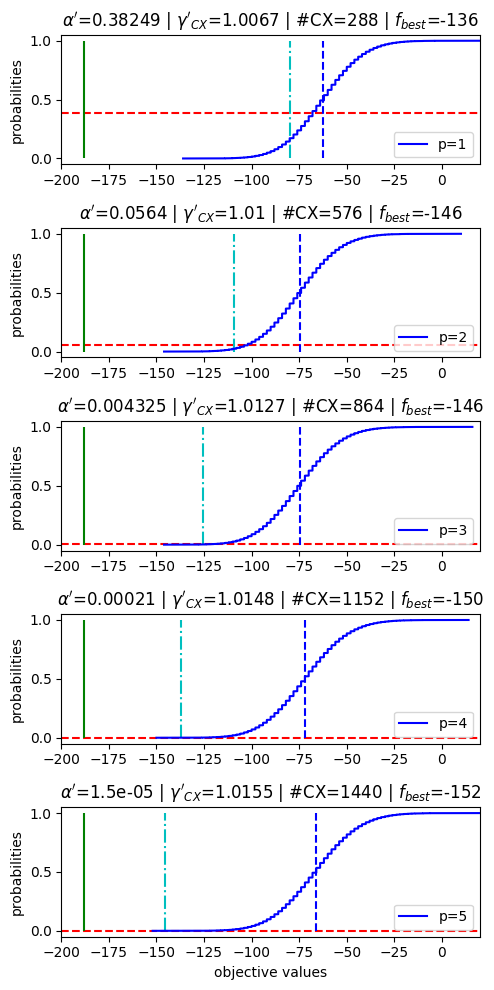

In [19]:
alpha_ = np.zeros(len(qcs))
best_val = np.zeros(len(qcs))
gamma_ = np.zeros(len(qcs))
mean = np.zeros(len(qcs))
gamma_cnot_ = np.zeros(len(qcs))

plt.subplots(5, 1, figsize=(5, 10))
for i in range(len(qcs)):

    cum_probs = np.cumsum(probs[i])
    rev_cum_probs = np.cumsum(probs[i][::-1])

    j = 1
    while np.sum(values[i][:j]@probs[i][:j])/cum_probs[j-1] < noise_free_exp_vals[i]:
        j += 1
    alpha_[i] = cum_probs[j-2]  # alpha' = fitted so CVaR matches expectation value
    best_val[i] = np.min(values[i])

    gamma_[i] = 1/alpha_[i]**2
    gamma_cnot_[i] = gamma_[i]**(1/num_cnots[i])

    mean[i] = values[i] @ probs[i]

    plt.subplot(5,1,i+1)

    plt.title(rf"$\alpha'$={np.round(alpha_[i], decimals=6)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_[i], decimals=4)} | #CX={num_cnots[i]} | $f_{{best}}$={int(best_val[i])}")
    plt.hlines(alpha_[i], -200, 20, 'r', linestyles='--')
    plt.vlines(opt_val, 0, 1, 'g')
    plt.vlines(noise_free_exp_vals[i], 0, 1, 'c', linestyles='-.')
    plt.vlines(mean[i], 0, 1, 'b', linestyles='--')
    plt.plot(values[i], cum_probs, 'b', label=f'p={i+1}')
    plt.xlim(-200, 20)
    plt.legend(loc='lower right')
    plt.ylabel('probabilities')
    if i==4:
        plt.xlabel('objective values')
    
plt.tight_layout()
plt.savefig(f'results/figure_4_{backend.name}.pdf')
plt.show()

## Save figure data
The values for the vertical reference lines can be found in Table 1.

In [20]:
import pandas as pd

In [23]:
for p in range(5):
    data = np.zeros((len(values[p]), 2))
    data[:, 0] = values[p]
    data[:, 1] = np.cumsum(probs[p])
    np.savez_compressed(f'results/data_figure_4_p{p+1}.npz', data)

# Table 2

In [24]:
def npr(x, d=3):
    return np.round(x, decimals=d)


print('==============================')
print('global optimum:  ', opt_val)
# print('gamma_cnot:      ', npr(gamma_cnot, 4))
print('==============================')

for i in range(len(qcs)):
    print(f'p={i+1}')
    print('==============================')
    print('#CNOTs:          ', npr(num_cnots[i], 4))
    print('noise-free mean: ', npr(noise_free_exp_vals[i]))
    print('noisy mean:      ', npr(mean[i]))
    print('best sample:     ', best_val[i])
    # print('sqrt(gamma):     ', npr(sqrt_gamma[i]))
    # print('alpha:           ', npr(alpha[i], 8))
    print('alpha_prime:     ', npr(alpha_[i], 8))
    print('gamma_cnot_prime:', npr(gamma_cnot_[i], 4))
    print('==============================')

global optimum:   -188.0
p=1
#CNOTs:           288
noise-free mean:  -79.786
noisy mean:       -62.365
best sample:      -136.0
alpha_prime:      0.38249
gamma_cnot_prime: 1.0067
p=2
#CNOTs:           576
noise-free mean:  -109.353
noisy mean:       -74.557
best sample:      -146.0
alpha_prime:      0.0564
gamma_cnot_prime: 1.01
p=3
#CNOTs:           864
noise-free mean:  -125.372
noisy mean:       -74.668
best sample:      -146.0
alpha_prime:      0.004325
gamma_cnot_prime: 1.0127
p=4
#CNOTs:           1152
noise-free mean:  -137.225
noisy mean:       -71.689
best sample:      -150.0
alpha_prime:      0.00021
gamma_cnot_prime: 1.0148
p=5
#CNOTs:           1440
noise-free mean:  -145.541
noisy mean:       -66.394
best sample:      -152.0
alpha_prime:      1.5e-05
gamma_cnot_prime: 1.0155


# Figure 5

In [25]:
def bootstrap(values, N, alphas):
    samples = np.random.choice(values, size=int(N))
    sorted_samples = sorted(samples)
    ks = np.ceil(N*np.array(alphas))
    return [np.mean(sorted_samples[:(int(k)+1)]) for k in ks]

In [26]:
N = 100_000
M = 10_000
cvars = np.zeros((M, len(alpha_)))
for i in range(5):
    for j in range(M):
        cvar_sample = bootstrap(values[i], N, [alpha_[i]])
        cvars[j, i] = cvar_sample[0]

In [27]:
cvar_vars = np.zeros(5)
for i in range(5):
    cvar_vars[i] = np.var(cvars[:, i])

In [28]:
fit = np.polyfit(np.log(alpha_[:]), np.log(cvar_vars[:]), 1)
fit
a = np.exp(fit[1])
b = -fit[0]
(a, b)

(0.0018448545238989936, 0.7772142241422012)

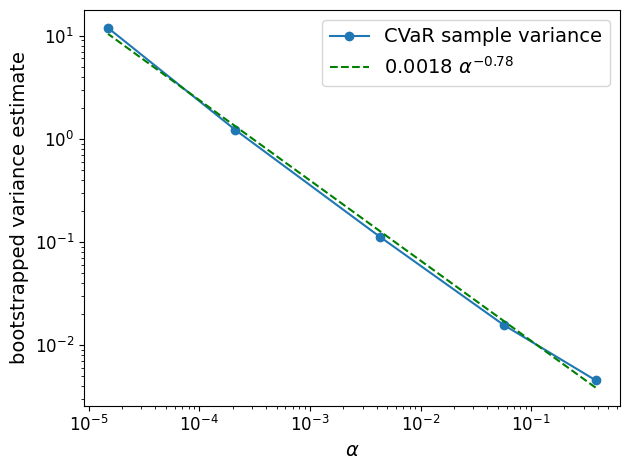

In [29]:
plt.loglog(alpha_, cvar_vars, 'o-', label='CVaR sample variance')
plt.plot(alpha_, a/np.array(alpha_)**b, 'g--', 
         label=rf'{np.round(a, decimals=4)} $\alpha^{{{-np.round(b, decimals=2)}}}$')
plt.legend(fontsize=14)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('bootstrapped variance estimate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'results/figure_7_{backend.name}.pdf')
plt.show()

## Save figure data

In [30]:
df = pd.DataFrame(columns=['alpha', 'cvar_var', 'fit'])
for i in range(len(alpha_)):
    row = [alpha_[i], cvar_vars[i], a/np.array(alpha_[i])**b]
    df.loc[i] = row
df.to_csv(f'results/data_figure_5.csv')